# 画像メディア工学１２回目

## 12. 射影変換の応用（射影変換による画像合成）
画像中の看板などに別の画像を合成する場合には，射影変換が利用できる．


### ライブラリの読み込み

In [1]:
%matplotlib inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

import cv2

## 画像の読み込み

以下のコマンドを実行すると，このファイルで利用する３つのファイルがColabにアップされます．

（別途画像ファイルをダウンロード・アップロードする必要はありません）

※ Colab以外で実行する場合には，画像ファイルをのダウンロードが必要です

https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09src.jpg
https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09dst.jpg
https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09.jpg

In [2]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09src.jpg -O img09src.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09dst.jpg -O img09dst.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09.jpg -O img09.jpg

--2023-01-09 16:27:32--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09src.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12135 (12K) [image/jpeg]
Saving to: ‘img09src.jpg’

img09src.jpg        100%[===================>]  11.85K  --.-KB/s    in 0s      

2023-01-09 16:27:32 (78.3 MB/s) - ‘img09src.jpg’ saved [12135/12135]

--2023-01-09 16:27:32--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img09dst.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54834 (54K) [imag

### 射影変換計算のための関数の定義
8.4.3節の(8.36)式までの計算．

In [3]:
def calcHomography(srcP,dstP):
    if srcP.shape != dstP.shape:
        print('number of points do not match')
        exit()
            
    Pnum = srcP.shape[0]
    A = np.zeros((2*Pnum,8))
    B = np.zeros((2*Pnum,1))
    H = np.zeros((3,3))
    
    for i in range(Pnum):        
        A[2*i]   = [srcP[i][0],srcP[i][1],1,0,0,0,
                    -srcP[i][0]*dstP[i][0],-srcP[i][1]*dstP[i][0]]
        A[2*i+1] = [0,0,0,srcP[i][0],srcP[i][1],1,
                    -srcP[i][0]*dstP[i][1],-srcP[i][1]*dstP[i][1]]
        B[2*i]   = [dstP[i][0]]
        B[2*i+1] = [dstP[i][1]]
    
    h = np.dot( np.linalg.inv(A), B )
    H = np.array([[h[0][0],h[1][0],h[2][0]],
                  [h[3][0],h[4][0],h[5][0]],
                  [h[6][0],h[7][0],1.0]])

    return H

### 画像の読み込み

In [4]:
dstI = cv2.imread('img09dst.jpg')
srcI = cv2.imread('img09src.jpg')
srcI = cv2.cvtColor(srcI, cv2.COLOR_BGR2RGB) # カラー画像はRGBの順を入れ替え

合成したい画像

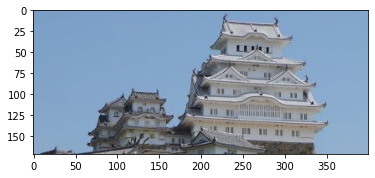

In [5]:
plt.imshow(srcI);

看板画像（合成先の画像）

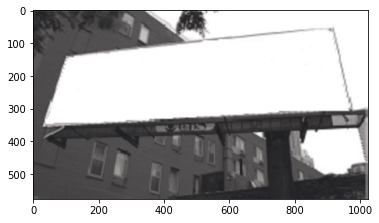

In [6]:
plt.imshow(dstI);

### 射影変換を計算するための対応点の指定

射影変換の計算に必要な最小の点数４点を指定（以下では，左上，左下，右下，右上の順)．

In [7]:
# 合成したい画像の4点
# ここでは画像全体で，左上は(0,0), 右下は(m,n)　m=画像の高さ,n=画像の幅
m,n = srcI.shape[:2]
srcP = np.array([[0,0],
                 [0,m],
                 [n,m],
                 [n,0]], dtype=np.float32)

# 合成先の座標4点
# 上の描画結果から4点の座標を読み取るなどして指定する
dstP = np.array([[100, 143],
                 [ 30, 353],
                 [980, 302],
                 [922,  50]], dtype=np.float32)

### 射影変換行列の計算
上で実装した関数を利用して計算できる．

ただし，実際にはOpenCVの関数(```cv2.getPerspectiveTransform()```)を利用したほうがよい．

（今回の例では，どちらを利用しても同じ結果となる）

In [8]:
H = calcHomography(srcP, dstP)
print(H)

#H = cv2.getPerspectiveTransform(srcP, dstP)
#print(H)

[[ 1.61343612e+00 -4.28437405e-01  1.00000000e+02]
 [-2.56445981e-01  9.68409792e-01  1.43000000e+02]
 [-4.78919615e-04 -7.15355355e-04  1.00000000e+00]]


### 射影変換による画像の変換
ここでは，```cv2.warpPerspective()```関数を利用する．

引数：変換前画像，射影変換行列，変換後画像のサイズ

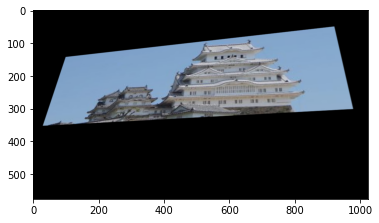

In [9]:
conv = cv2.warpPerspective(srcI, H, (dstI.shape[1],dstI.shape[0]))
plt.imshow(conv);

### 画像の合成
合成先画像```(dstI)```に，変換後の画像を合成する．

ここでは，```conv```の画素値が```0```ではない領域のみを```dstI```にコピーすることで合成を実現している．

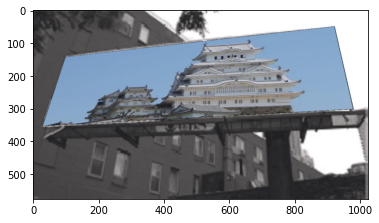

In [10]:
dstI[conv!=0]=conv[conv!=0]
plt.imshow(dstI);

### 課題．
上の例とは逆で，傾いて撮影された画像を正面向き画像に変換することもできる．

以下の行列```dstP2```を適切に修正し，正面向き画像が生成できてるようにしてください．
その際の行列```dstP2```を提出してください．

変換前画像の表示：

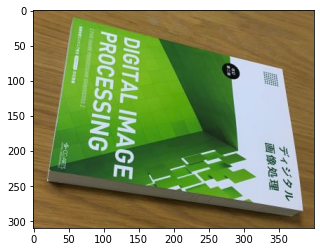

In [11]:
srcI2 = cv2.imread('img09.jpg')
srcI2 = cv2.cvtColor(srcI2, cv2.COLOR_BGR2RGB) # カラー画像はRGBの順を入れ替え
plt.imshow(srcI2);

射影変換のための対応点の指定：

上の描画表示から，変換したい画像の範囲の座標４点を読み取り，```srcP2```に代入すれば良い．

```dstP2```の座標は，変換後画像が縦長になるように指定済みのため，それと対応するように```srcP2```の座標を指定すると，正面に変換された画像が生成される．

In [12]:
# 合成したい画像範囲の４点
# 既に正しい座標が指定されている
m,n = srcI2.shape[:2]
srcP2 = np.array([[355, 80],
                  [380,290],
                  [ 18,233],
                  [ 55,  5]], dtype=np.float32)

# 合成先の座標4点
# 以下では300x400の縦長画像となるよう指定されているが，順番が正しくないため，正しい正面向き画像となっていない．
# 正しい正面画像となるように，dstP2行列を修正してください．

dstP2 = np.array([[  0,   0],
                  [  0, 400],
                  [300, 400],
                  [300,   0]], dtype=np.float32)

射影変換の計算と画像の変換

[[-1.00128250e+00  1.19200298e-01  3.45919265e+02]
 [-4.99711766e-01  1.99884706e+00  1.74899118e+01]
 [-5.95082493e-04  8.42393347e-04  1.00000000e+00]]


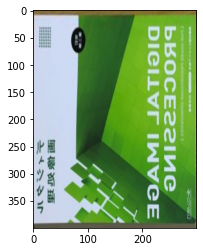

In [13]:
H = cv2.getPerspectiveTransform(srcP2, dstP2)
print(H)

conv = cv2.warpPerspective(srcI2, H, (300, 400))
plt.imshow(conv);